In [1]:
""" Importando bibliotecas """

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Para modelos de Scikit-learn
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier # Para KNN
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV, StratifiedKFold # GridSearchCV para otimização, StratifiedKFold para validação cruzada

# Para XGBoost
import xgboost as xgb

# Para Keras (parte do TensorFlow)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
# Carregar os dados pré-processados e salvos do notebook anterior
try:
    X_train = pd.read_csv('../data/processed/X_train.csv')
    X_test = pd.read_csv('../data/processed/X_test.csv')
    y_train = pd.read_csv('../data/processed/y_train.csv').squeeze() # .squeeze() para converter para Series, se necessário
    y_test = pd.read_csv('../data/processed/y_test.csv').squeeze()   # .squeeze() para converter para Series, se necessário
    print("Dados de treino e teste carregados com sucesso.")
except FileNotFoundError:
    print("Erro: Certifique-se de que os arquivos X_train.csv, X_test.csv, y_train.csv, y_test.csv")
    print("foram salvos na pasta '../data/processed/' pelo notebook de pré-processamento.")
    # Saia ou adicione lógica para lidar com o erro de forma apropriada
    # Por exemplo: exit() ou raise FileNotFoundError

print("Shape de X_train:", X_train.shape)
print("Shape de X_test:", X_test.shape)
print("Shape de y_train:", y_train.shape)
print("Shape de y_test:", y_test.shape)

Dados de treino e teste carregados com sucesso.
Shape de X_train: (1849, 50)
Shape de X_test: (617, 50)
Shape de y_train: (1849,)
Shape de y_test: (617,)


### Função para Avaliação e Visualização de Resultados

In [3]:
def evaluate_model(model_name, y_true, y_pred, y_pred_proba=None):
    """
    Docstring: Avalia o modelo e exibe métricas de desempenho, relatório de classificação e matriz de confusão.
    """
    print(f"--- Avaliação do Modelo: {model_name} ---")
    print("\nRelatório de Classificação:")
    print(classification_report(y_true, y_pred))

    print("\nMatriz de Confusão:")
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Ficou (0)', 'Saiu (1)'],
                yticklabels=['Ficou (0)', 'Saiu (1)'])
    plt.title(f'Matriz de Confusão para {model_name}')
    plt.xlabel('Predito')
    plt.ylabel('Real')
    plt.show()

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    print(f"Acurácia: {accuracy:.4f}")
    print(f"Precisão: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print("-" * 50)

### Modelos de Machine Learning e Deep Learning

#### Regressão Logística

Iniciando treinamento e otimização para Regressão Logística...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Melhores parâmetros para Regressão Logística: {'C': 10, 'solver': 'liblinear'}
--- Avaliação do Modelo: Regressão Logística Otimizada ---

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.83      0.79      0.81       309
           1       0.80      0.84      0.82       308

    accuracy                           0.81       617
   macro avg       0.81      0.81      0.81       617
weighted avg       0.81      0.81      0.81       617


Matriz de Confusão:


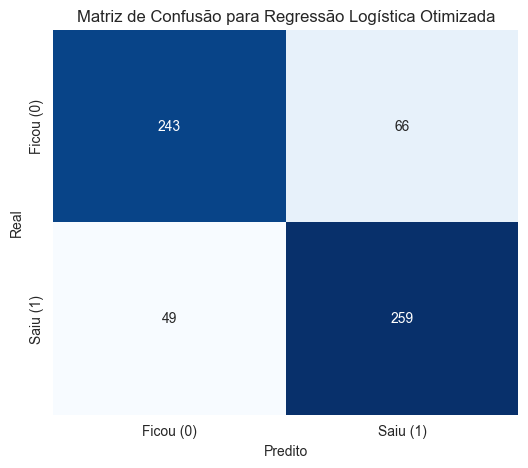

Acurácia: 0.8136
Precisão: 0.7969
Recall: 0.8409
F1-Score: 0.8183
--------------------------------------------------


In [4]:
#  parâmetros para otimização ==> (GridSearchCV)
param_grid_lr = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'lbfgs']
}

# Configurar GridSearchCV
grid_search_lr = GridSearchCV(
    estimator=LogisticRegression(random_state=42, max_iter=200),
    param_grid=param_grid_lr,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring='f1', # obs: f1 é bom para classes desbalanceadas, mesmo após SMOTE!!
    n_jobs=-1, # Usar todos os núcleos da CPU
    verbose=1
)

print("Iniciando treinamento e otimização para Regressão Logística...")
grid_search_lr.fit(X_train, y_train)

best_lr_model = grid_search_lr.best_estimator_
print(f"Melhores parâmetros para Regressão Logística: {grid_search_lr.best_params_}")

# Previsões no conjunto de teste
y_pred_lr = best_lr_model.predict(X_test)
y_pred_proba_lr = best_lr_model.predict_proba(X_test)[:, 1]

# Avaliar o modelo
evaluate_model("Regressão Logística Otimizada", y_test, y_pred_lr, y_pred_proba_lr)

#### Random Forest Classifier


Iniciando treinamento e otimização para Random Forest...
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Melhores parâmetros para Random Forest: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
--- Avaliação do Modelo: Random Forest Classifier Otimizado ---

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.90      0.95      0.93       309
           1       0.95      0.90      0.92       308

    accuracy                           0.92       617
   macro avg       0.93      0.92      0.92       617
weighted avg       0.93      0.92      0.92       617


Matriz de Confusão:


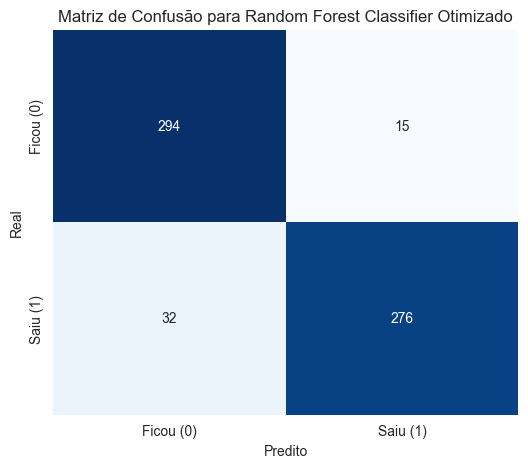

Acurácia: 0.9238
Precisão: 0.9485
Recall: 0.8961
F1-Score: 0.9215
--------------------------------------------------


In [5]:
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# Configurar GridSearchCV
grid_search_rf = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid_rf,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

print("\nIniciando treinamento e otimização para Random Forest...")
grid_search_rf.fit(X_train, y_train)

best_rf_model = grid_search_rf.best_estimator_
print(f"Melhores parâmetros para Random Forest: {grid_search_rf.best_params_}")

# Previsões no conjunto de teste
y_pred_rf = best_rf_model.predict(X_test)
y_pred_proba_rf = best_rf_model.predict_proba(X_test)[:, 1]

# Avaliar o modelo
evaluate_model("Random Forest Classifier Otimizado", y_test, y_pred_rf, y_pred_proba_rf)

#### K-Nearest Neighbors (KNN)


Iniciando treinamento e otimização para KNN...
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Melhores parâmetros para KNN: {'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}
--- Avaliação do Modelo: K-Nearest Neighbors (KNN) Otimizado ---

Relatório de Classificação:
              precision    recall  f1-score   support

           0       1.00      0.80      0.89       309
           1       0.83      1.00      0.91       308

    accuracy                           0.90       617
   macro avg       0.92      0.90      0.90       617
weighted avg       0.92      0.90      0.90       617


Matriz de Confusão:


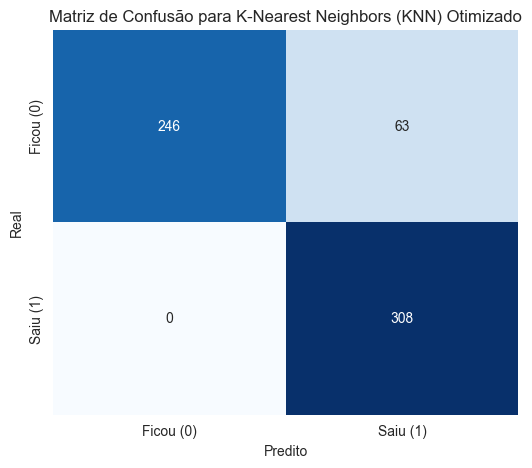

Acurácia: 0.8979
Precisão: 0.8302
Recall: 1.0000
F1-Score: 0.9072
--------------------------------------------------


In [6]:
param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

# Configurar GridSearchCV
grid_search_knn = GridSearchCV(
    estimator=KNeighborsClassifier(),
    param_grid=param_grid_knn,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

print("\nIniciando treinamento e otimização para KNN...")
grid_search_knn.fit(X_train, y_train)

best_knn_model = grid_search_knn.best_estimator_
print(f"Melhores parâmetros para KNN: {grid_search_knn.best_params_}")

# Previsões no conjunto de teste
y_pred_knn = best_knn_model.predict(X_test)
y_pred_proba_knn = best_knn_model.predict_proba(X_test)[:, 1]

# Avaliar o modelo
evaluate_model("K-Nearest Neighbors (KNN) Otimizado", y_test, y_pred_knn, y_pred_proba_knn)

 #### XGBoost Classifier


Iniciando treinamento e otimização para XGBoost...
Fitting 5 folds for each of 32 candidates, totalling 160 fits


D:\Documents\Ambientes\Python3.11\DSvenv\Lib\site-packages\xgboost\training.py:183: UserWarning: [19:23:34] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Melhores parâmetros para XGBoost: {'colsample_bytree': 0.7, 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.9}
--- Avaliação do Modelo: XGBoost Classifier Otimizado ---

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.91      0.96      0.93       309
           1       0.96      0.90      0.93       308

    accuracy                           0.93       617
   macro avg       0.93      0.93      0.93       617
weighted avg       0.93      0.93      0.93       617


Matriz de Confusão:


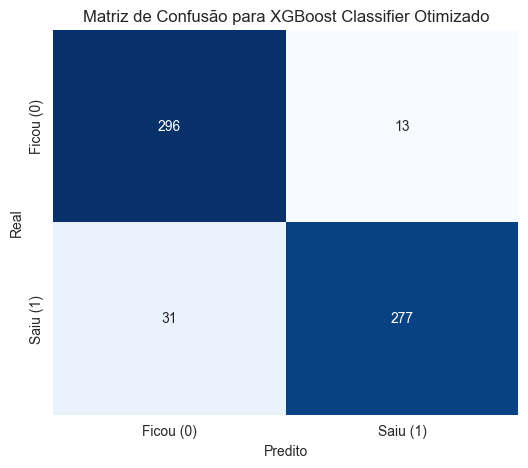

Acurácia: 0.9287
Precisão: 0.9552
Recall: 0.8994
F1-Score: 0.9264
--------------------------------------------------


In [7]:
param_grid_xgb = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5],
    'subsample': [0.7, 0.9],
    'colsample_bytree': [0.7, 0.9]
}

# Configurar GridSearchCV
grid_search_xgb = GridSearchCV(
    estimator=xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', use_label_encoder=False, random_state=42),
    param_grid=param_grid_xgb,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

print("\nIniciando treinamento e otimização para XGBoost...")
grid_search_xgb.fit(X_train, y_train)

best_xgb_model = grid_search_xgb.best_estimator_
print(f"Melhores parâmetros para XGBoost: {grid_search_xgb.best_params_}")

# Previsões no conjunto de teste
y_pred_xgb = best_xgb_model.predict(X_test)
y_pred_proba_xgb = best_xgb_model.predict_proba(X_test)[:, 1]

# Avaliar o modelo
evaluate_model("XGBoost Classifier Otimizado", y_test, y_pred_xgb, y_pred_proba_xgb)

#### Deep Learning com Keras (TensorFlow)

In [8]:
def create_keras_model(input_dim):
    model = Sequential([
        Dense(64, activation='relu', input_shape=(input_dim,)),
        Dropout(0.3), # ==> regularização
        Dense(32, activation='relu'),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# modelo
input_dim_keras = X_train.shape[1]
keras_model = create_keras_model(input_dim_keras)

# Callbacks para Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

print("\nIniciando treinamento do modelo Deep Learning (Keras)...")
history = keras_model.fit(
    X_train, y_train,
    epochs=100, # o early stopping aqui é pra parar quando não houver mais melhora
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=0
)

# Avaliar o modelo no conjunto de teste
y_pred_proba_keras = keras_model.predict(X_test).ravel()
y_pred_keras = (y_pred_proba_keras > 0.5).astype(int)

print("Treinamento e previsão do modelo Keras concluídos.")

D:\Documents\Ambientes\Python3.11\DSvenv\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Iniciando treinamento do modelo Deep Learning (Keras)...
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Treinamento e previsão do modelo Keras concluídos.


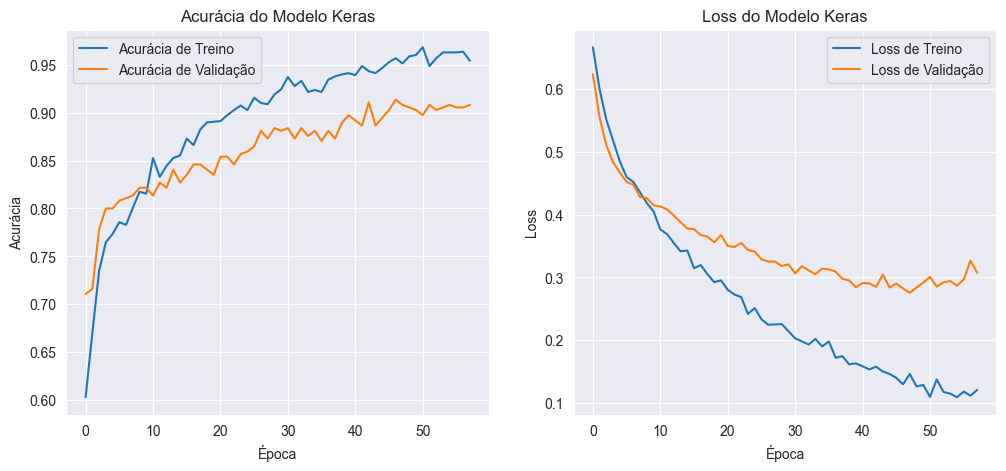

--- Avaliação do Modelo: Deep Learning (Keras) ---

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.94      0.89      0.91       309
           1       0.89      0.94      0.92       308

    accuracy                           0.92       617
   macro avg       0.92      0.92      0.92       617
weighted avg       0.92      0.92      0.92       617


Matriz de Confusão:


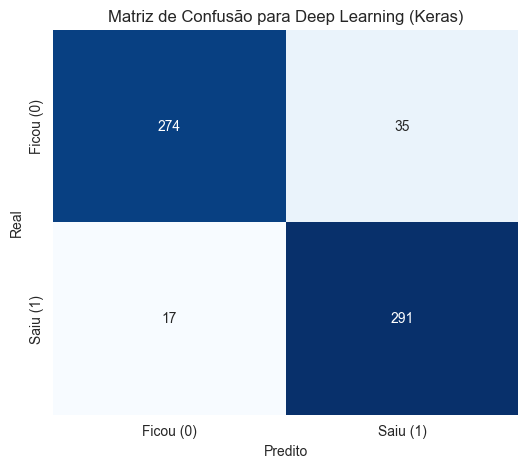

Acurácia: 0.9157
Precisão: 0.8926
Recall: 0.9448
F1-Score: 0.9180
--------------------------------------------------


In [9]:
''' Visualização do histórico de treinamento do modelo Keras '''

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Acurácia de Treino')
plt.plot(history.history['val_accuracy'], label='Acurácia de Validação')
plt.title('Acurácia do Modelo Keras')
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Loss de Treino')
plt.plot(history.history['val_loss'], label='Loss de Validação')
plt.title('Loss do Modelo Keras')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.legend()
plt.show()

# avaliação usando a função auxiliar
evaluate_model("Deep Learning (Keras)", y_test, y_pred_keras, y_pred_proba_keras)